In [ ]:
!pip install torch torchvision
!pip install transformers
!pip install pandas
!pip install numpy
!pip install sentencepiece
!!pip install sentence-splitter





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.6 MB/s eta 0:00:00


['Collecting sentence-splitter',
 '  Downloading sentence_splitter-1.4-py2.py3-none-any.whl (44 kB)',
 '\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/45.0 kB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b45.0/45.0 kB\x1b \x1b1.4 MB/s\x1b eta \x1b0:00:00\x1b',
 '\x1b[?25hRequirement already satisfied: regex>=2017.12.12 in /usr/local/lib/python3.10/dist-packages (from sentence-splitter) (2023.6.3)',
 'Installing collected packages: sentence-splitter',
 'Successfully installed sentence-splitter-1.4']

In [ ]:
!pip install livelossplot --quiet
!pip install emoji --quiet



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.8/361.8 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from transformers import BertForSequenceClassification,BertTokenizerFast,AdamW,logging
logging.set_verbosity_error()
import torch

from livelossplot import PlotLosses

pd.options.display.max_colwidth = 1000
pd.set_option('display.expand_frame_repr', False)

import re,emoji
import imageio,glob

# **Imports**

In [ ]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW,AutoModelForQuestionAnswering, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import DebertaTokenizer, DebertaModel, BartTokenizer
import math

# **Model loading**

In [ ]:
# Use a GPU if you have one available (Runtime -> Change runtime type -> GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds for reproducibility
random.seed(26)
np.random.seed(26)
torch.manual_seed(26)

tokenizer = AutoTokenizer.from_pretrained("michiyasunaga/BioLinkBERT-base")

model = AutoModelForSequenceClassification.from_pretrained("michiyasunaga/BioLinkBERT-base")
model.to(device) # Send the model to the GPU if we have one



BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28895, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
learning_rate = 1.381809842030197e-05
layerwise_learning_rate_decay = 0.9
weight_decay = 0.01
adam_epsilon = 1e-6
use_bertadam = False
# scheduler params
num_epochs = 5
num_warmup_steps = 0
_model_type = 'bert'

def get_optimizer_grouped_parameters(
    model, model_type,
    learning_rate, weight_decay,
    layerwise_learning_rate_decay
):
    no_decay = ["bias", "LayerNorm.weight"]
    # initialize lr for task specific layer
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if "classifier" in n or "pooler" in n],
            "weight_decay": 0.0,
            "lr": learning_rate,
        },
    ]
    # initialize lrs for every layer
    num_layers = model.config.num_hidden_layers
    layers = [getattr(model, model_type).embeddings] + list(getattr(model, model_type).encoder.layer)
    layers.reverse()
    lr = learning_rate
    for layer in layers:
        lr *= layerwise_learning_rate_decay
        optimizer_grouped_parameters += [
            {
                "params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": weight_decay,
                "lr": lr,
            },
            {
                "params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
                "lr": lr,
            },
        ]
    return optimizer_grouped_parameters


In [ ]:
grouped_optimizer_params = get_optimizer_grouped_parameters(
    model, _model_type,
    learning_rate, weight_decay,
    layerwise_learning_rate_decay
)
optimizer = AdamW(
    grouped_optimizer_params,
    lr=learning_rate,
    eps=adam_epsilon,
    correct_bias=not use_bertadam
)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_epochs
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
(learning_rates1, learning_rates2, learning_rates3, learning_rates4,
learning_rates5, learning_rates6, learning_rates7, learning_rates8,
learning_rates9, learning_rates10, learning_rates11, learning_rates12,
learning_rates13, learning_rates14) = [[] for i in range(14)]

def collect_lr(optimizer):
    learning_rates1.append(optimizer.param_groups[0]["lr"])
    learning_rates2.append(optimizer.param_groups[2]["lr"])
    learning_rates3.append(optimizer.param_groups[4]["lr"])
    learning_rates4.append(optimizer.param_groups[6]["lr"])
    learning_rates5.append(optimizer.param_groups[8]["lr"])
    learning_rates6.append(optimizer.param_groups[10]["lr"])
    learning_rates7.append(optimizer.param_groups[12]["lr"])
    learning_rates8.append(optimizer.param_groups[14]["lr"])
    learning_rates9.append(optimizer.param_groups[16]["lr"])
    learning_rates10.append(optimizer.param_groups[18]["lr"])
    learning_rates11.append(optimizer.param_groups[20]["lr"])
    learning_rates12.append(optimizer.param_groups[22]["lr"])
    learning_rates13.append(optimizer.param_groups[24]["lr"])
    learning_rates14.append(optimizer.param_groups[26]["lr"])

collect_lr(optimizer)
for epoch in range(num_epochs):
    optimizer.step()
    scheduler.step()
    collect_lr(optimizer)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df=pd.read_csv('./new_data_mutagenicity.csv')

# Apply the function to the column
df['label'] = df['label'].apply(lambda x: x.startswith("['True"))
#df['label'] = df['label'].apply(lambda x: x[0] == "['False - AMES non Mutagenic']")

new_column_names = {'text': 'Abstract', 'label': 'AMES'}
df.rename(columns=new_column_names, inplace=True)

train_data_df, dev_data_df = train_test_split(df, test_size = 0.2, random_state = 42)

# **Data loading**

In [ ]:
def encode_data(tokenizer, passages,questions,max_length):
    """Encode the question/passage pairs into features than can be fed to the model."""
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):
        encoded_data = tokenizer.encode_plus(passage,question, max_length=max_length, pad_to_max_length=True, truncation='longest_first')
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)

# Loading data
passages_train = train_data_df.Abstract.values
questions_train = train_data_df.questions.values
answers_train = train_data_df.AMES.values.astype(int)

passages_dev = dev_data_df.Abstract.values
questions_dev = dev_data_df.questions.values
answers_dev = dev_data_df.AMES.values.astype(int)

# Encoding data
max_seq_length = 50
input_ids_train, attention_masks_train = encode_data(tokenizer, questions_train, passages_train, max_seq_length)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, questions_dev, passages_dev, max_seq_length)

train_features = (input_ids_train, attention_masks_train, answers_train)
dev_features = (input_ids_dev, attention_masks_dev, answers_dev)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
batch_size = 2

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)




In [ ]:
len(layers_to_visualize)

12

In [ ]:
dim_reducer = TSNE(n_components=2)
layers_to_visualize=[i for i in range(12)]

def visualize_layerwise_embeddings(hidden_states,masks,ys,epoch,title,layers_to_visualize=layers_to_visualize):
    print('visualize_layerwise_embeddings for',title,'epoch',epoch)
    global dim_reducer
    !mkdir -p /tmp/plots/{title}
    num_layers = len(layers_to_visualize)
    fig = plt.figure(figsize=(24,(num_layers/4)*6)) #each subplot of size 6x6
    ax = [fig.add_subplot(int(num_layers/4),4,i+1) for i in range(num_layers)]
    ys = ys.numpy().reshape(-1)
    for i,layer_i in enumerate(layers_to_visualize):#range(hidden_states):
        layer_hidden_states = hidden_states[layer_i]
        averaged_layer_hidden_states = torch.div(layer_hidden_states.sum(dim=1),masks.sum(dim=1,keepdim=True))
        layer_dim_reduced_vectors = dim_reducer.fit_transform(averaged_layer_hidden_states.numpy())
        df = pd.DataFrame.from_dict({'x':layer_dim_reduced_vectors[:,0],'y':layer_dim_reduced_vectors[:,1],'label':ys})
        df.label = df.label.astype(int)
        sns.scatterplot(data=df,x='x',y='y',hue='label',ax=ax[i])
        fig.suptitle(f"{title}: epoch {epoch}")
        ax[i].set_title(f"layer {layer_i+1}")
    plt.savefig(f'/tmp/plots/{title}/{epoch}',format='png',pad_inches=0)
    print()

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
EPOCHS = 8 #@param {type:"slider", min:0, max:10, step:1}
LEARNING_RATE = 0.00005 #@param [1e-5,5e-5,1e-4] {type:"raw"}
BATCH_SIZE = 2 #@param [8,16,32,64] {type:"raw"}
MAX_SEQ_LEN = 50   #@param [50,100,512] {type:"raw"}

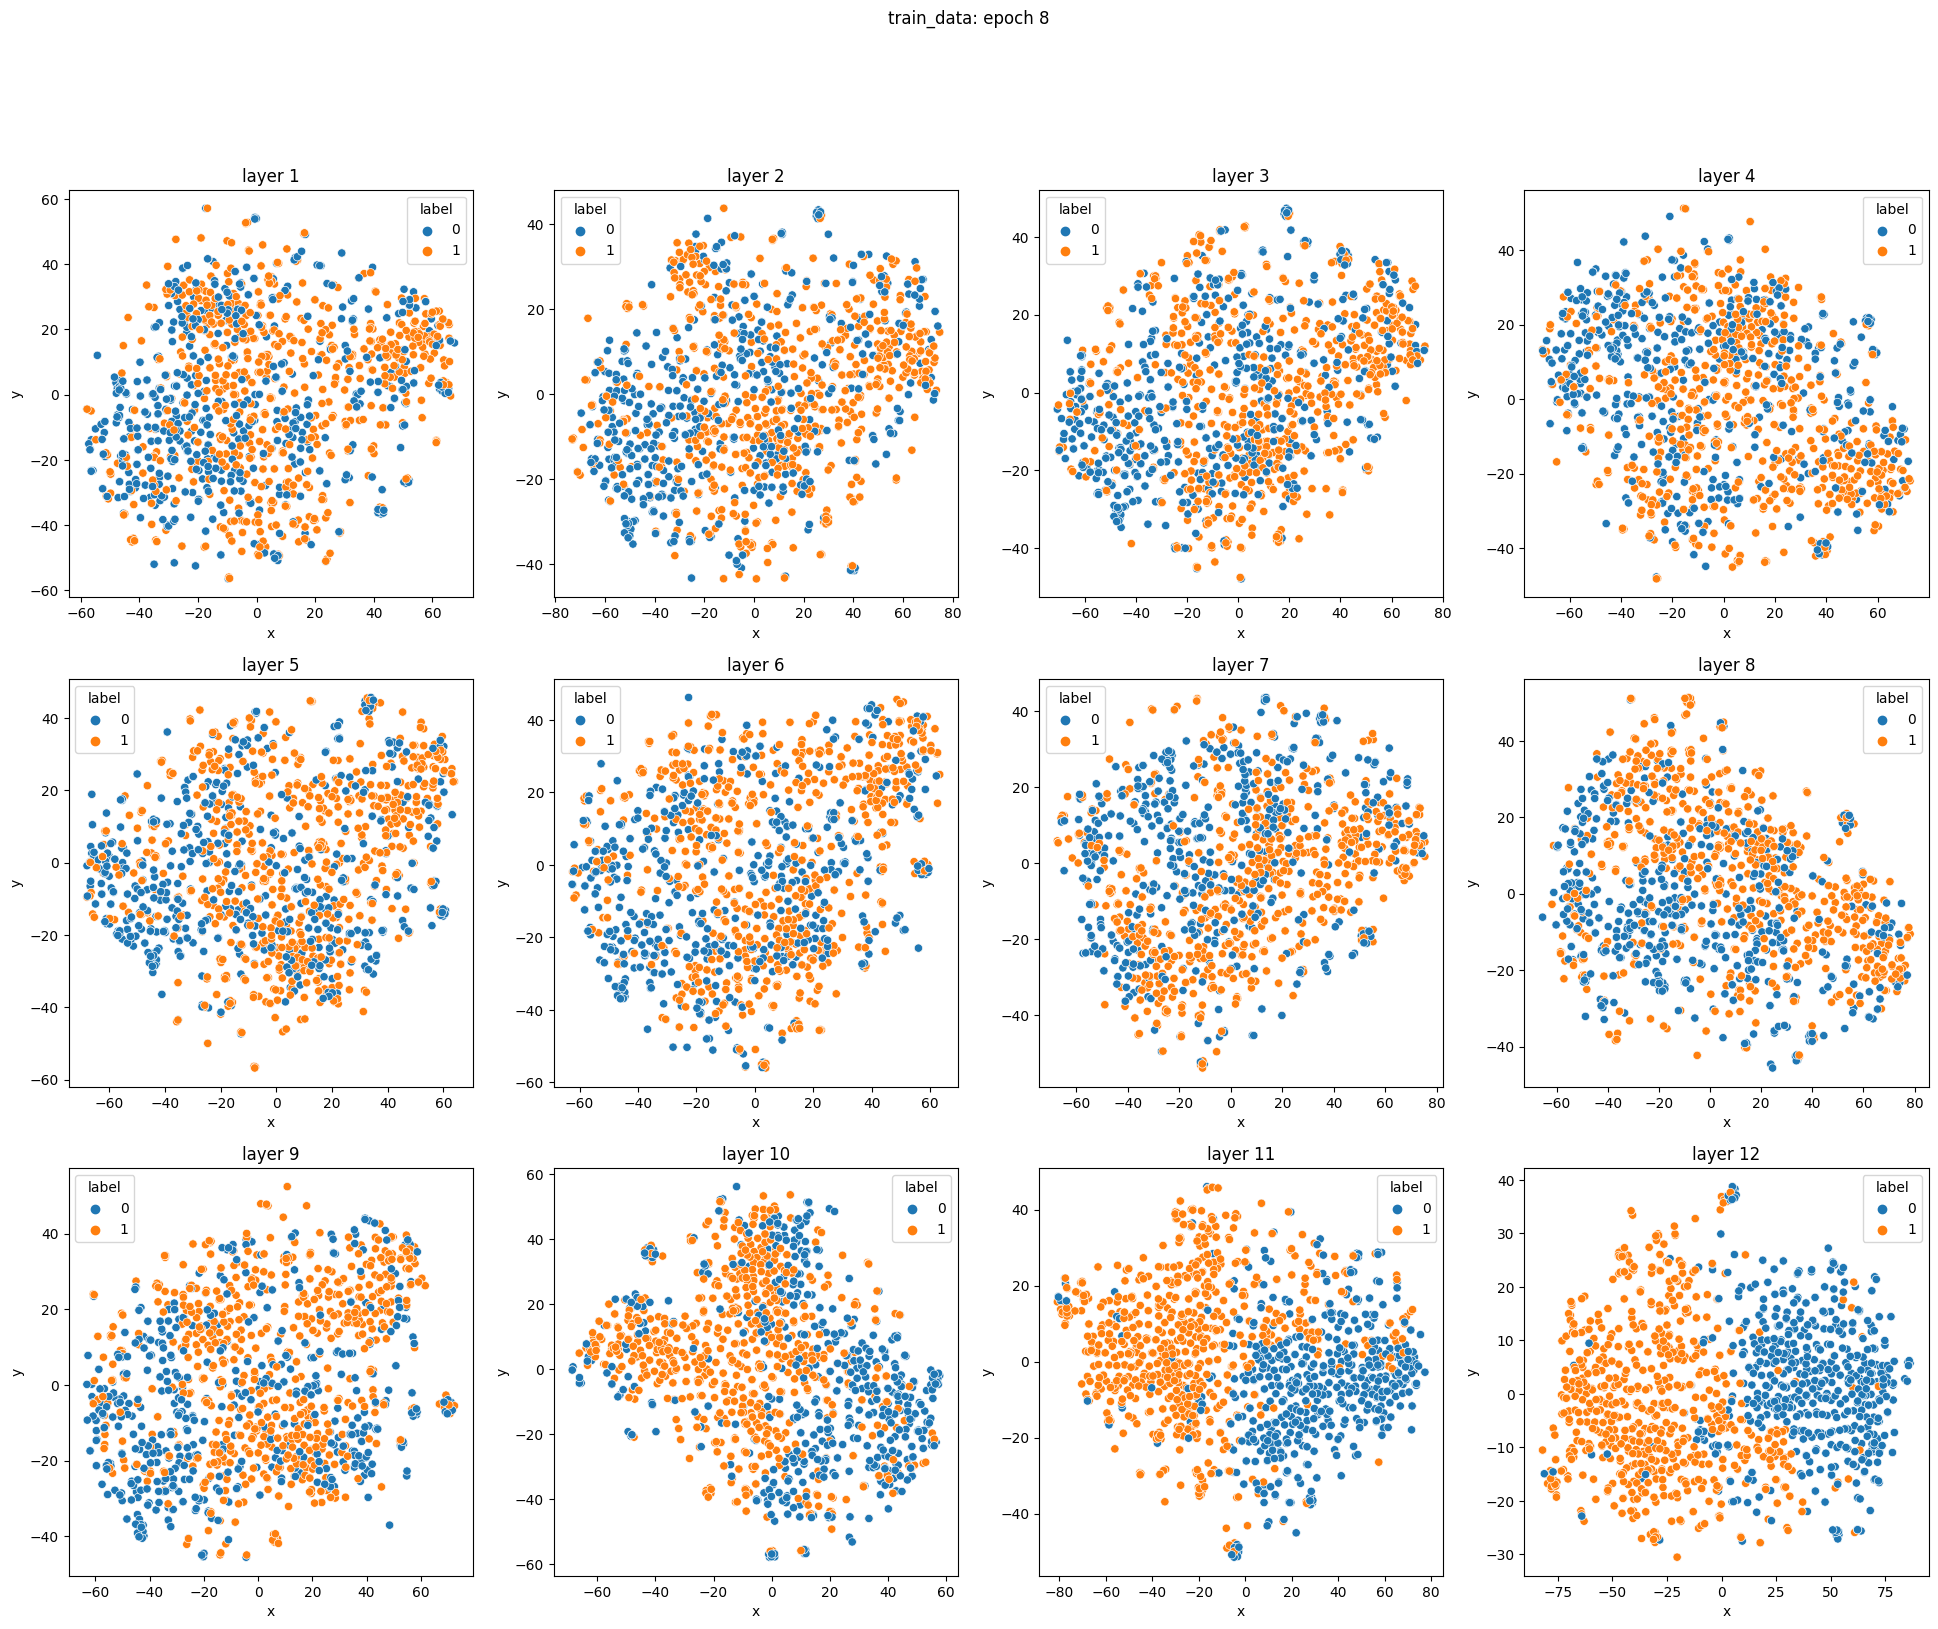

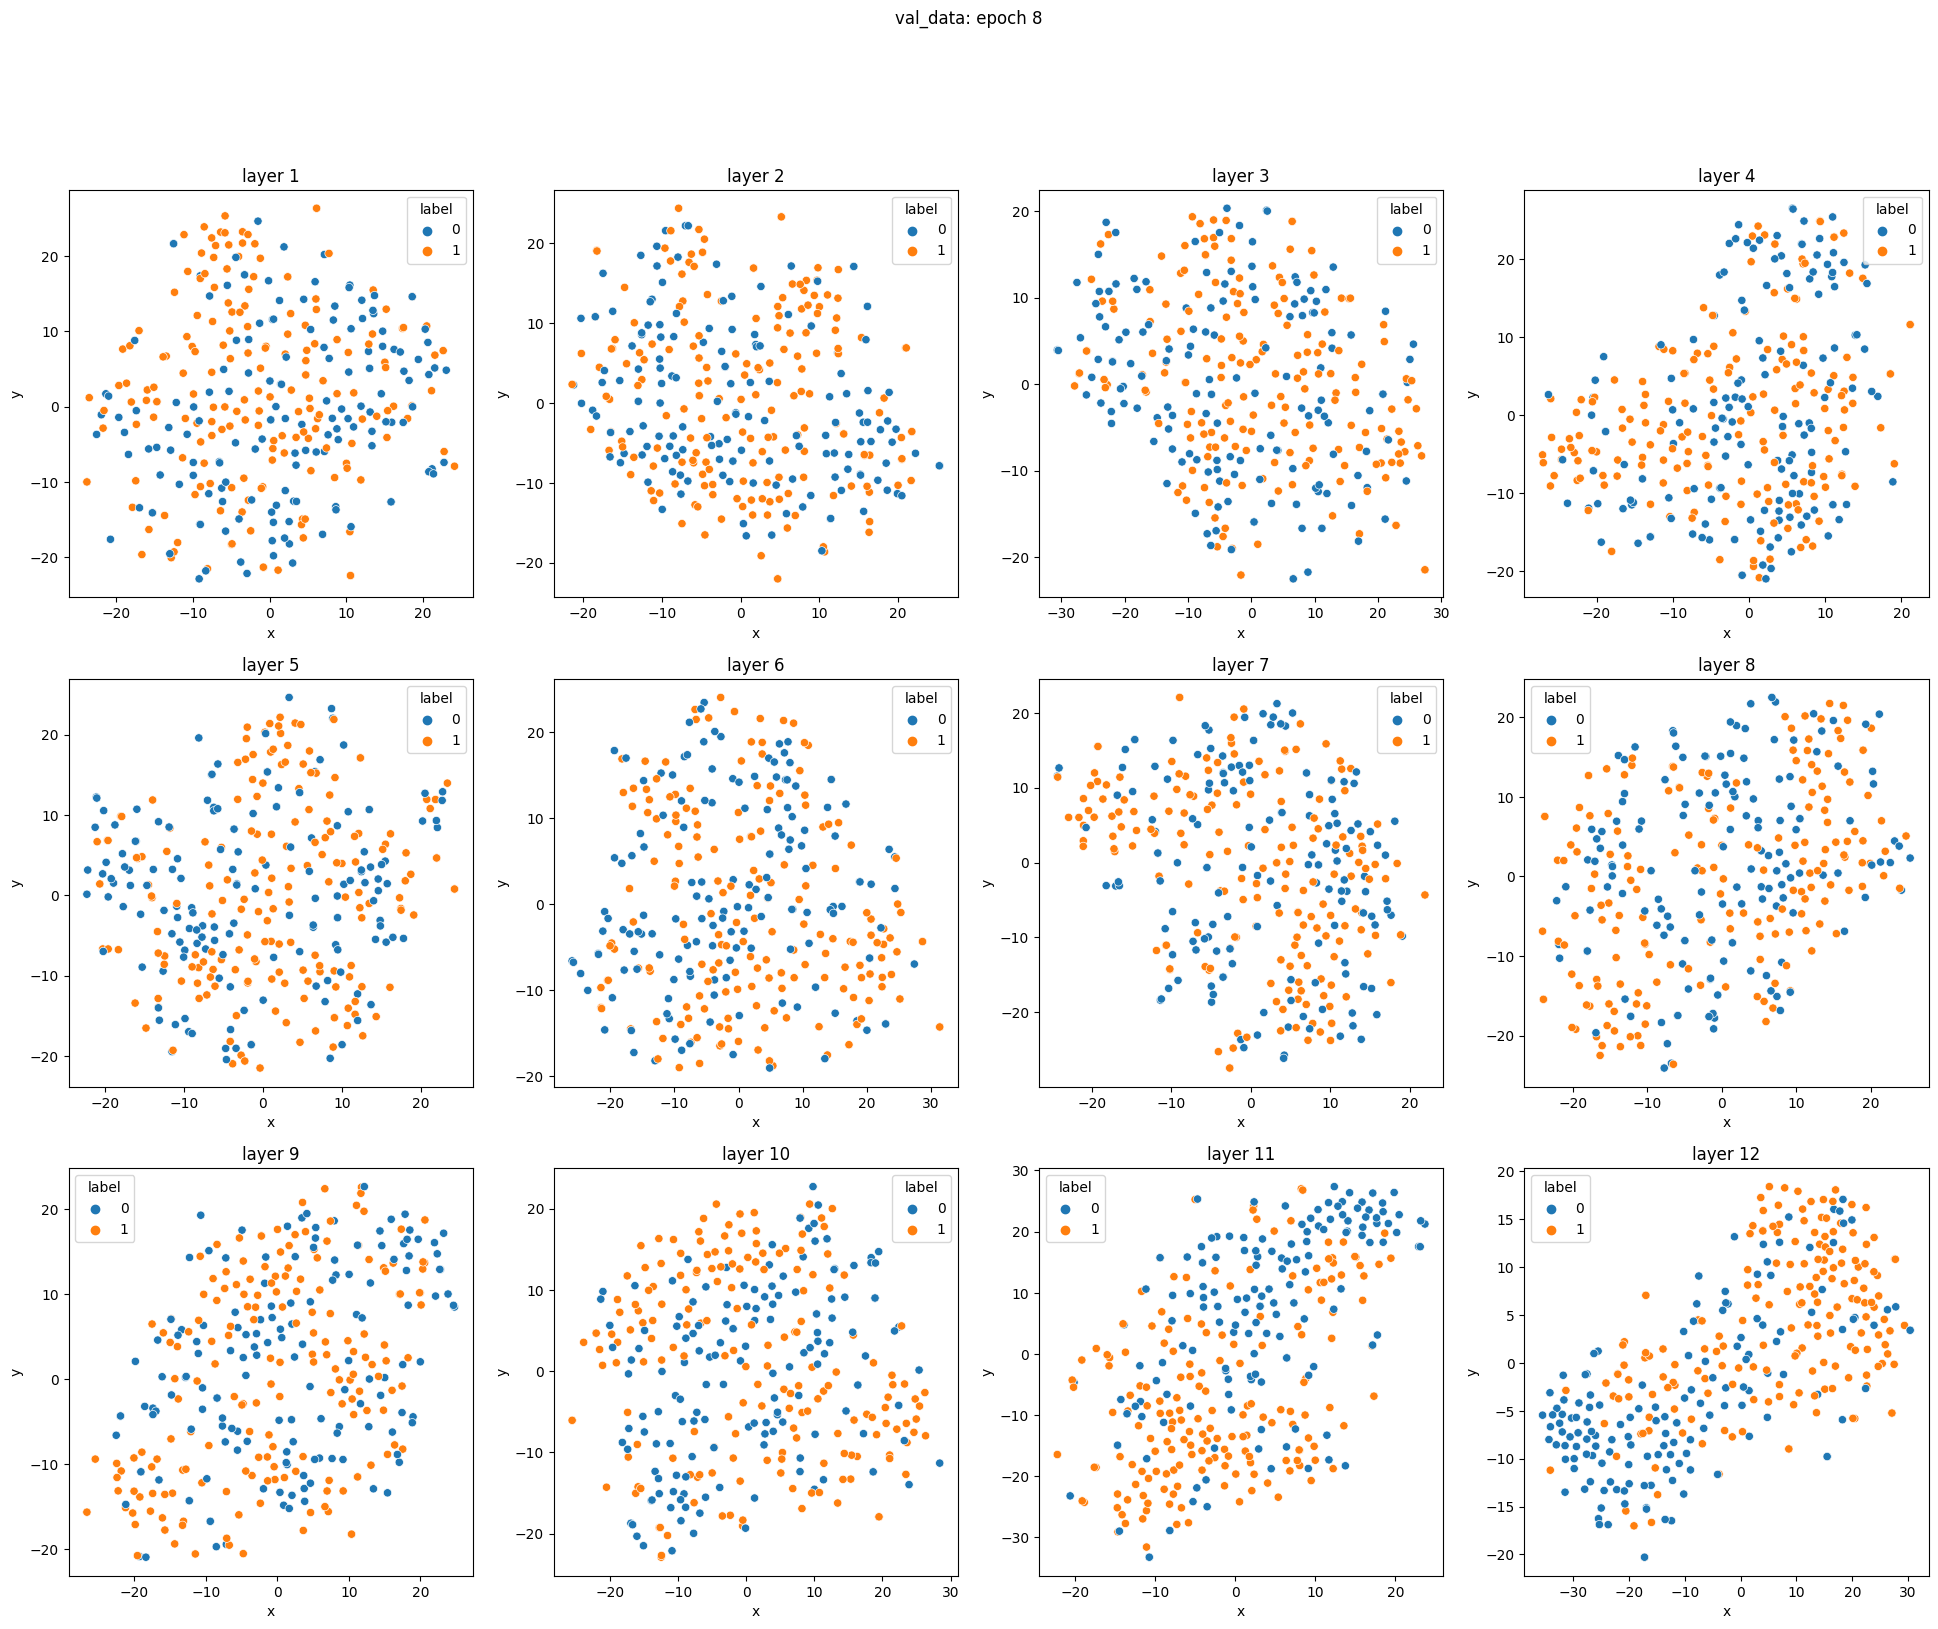

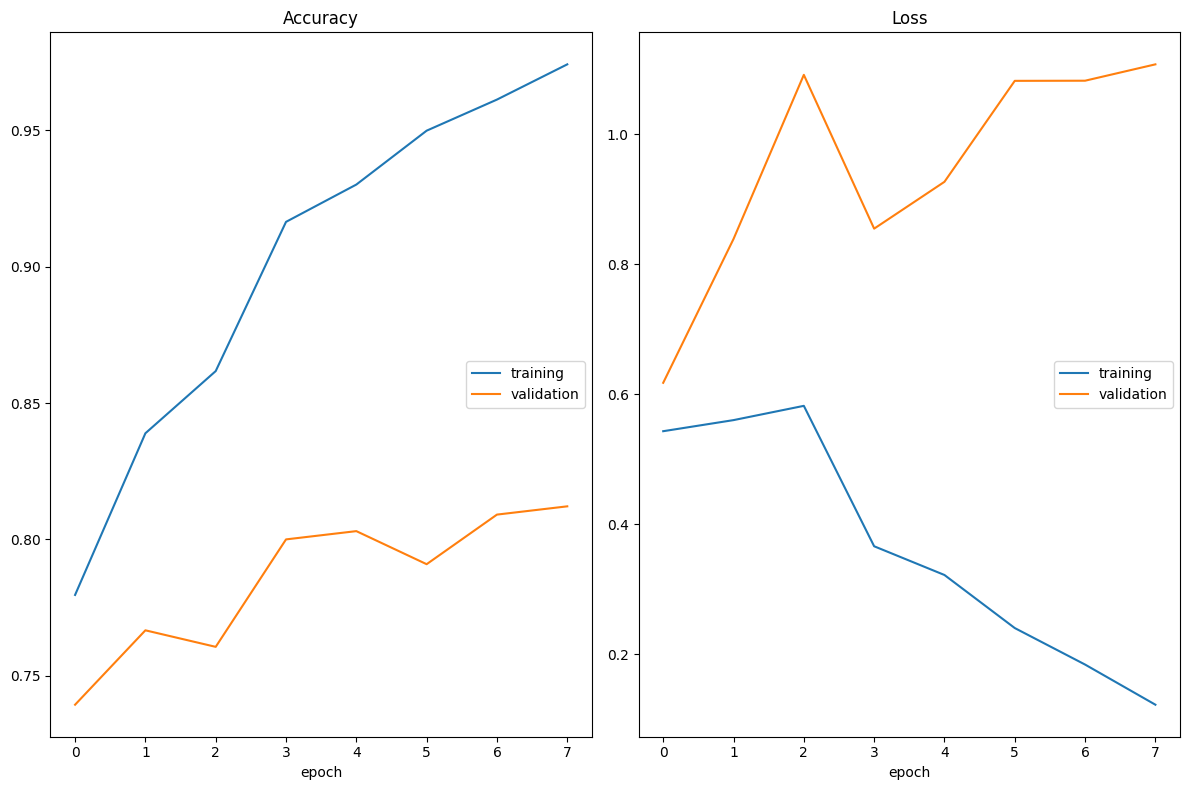

Accuracy
	training         	 (min:    0.780, max:    0.974, cur:    0.974)
	validation       	 (min:    0.739, max:    0.812, cur:    0.812)
Loss
	training         	 (min:    0.122, max:    0.582, cur:    0.122)
	validation       	 (min:    0.618, max:    1.108, cur:    1.108)
CPU times: user 1h 6min 28s, sys: 56min 30s, total: 2h 2min 59s
Wall time: 1h 38min 59s


In [ ]:
%%time
loss_function = torch.nn.NLLLoss()
#optimizer = AdamW(lr=LEARNING_RATE,params=model.parameters())
liveloss = PlotLosses()
for epoch in range(EPOCHS+1):
    print(f'epoch = {epoch}')
    logs = {}
    if epoch:   #do not train on 0th epoch, only visualize on it
        model.train(True)   #toggle model in train mode
        train_correct_preds,train_total_preds,train_total_loss = 0,0,0.0
        for step, batch in enumerate(train_dataloader):
            model.zero_grad()
            sent_ids,masks = batch[0], batch[1]
            sent_ids = sent_ids.to(device)
            masks = masks.to(device)
            y = batch[2].to(device)
            model_out = model(sent_ids,masks,return_dict=True)
            log_probs = torch.nn.functional.log_softmax(model_out.logits, dim=1)
            loss = loss_function(log_probs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #gradient clipping to prevent exploding gradients
            optimizer.step()
            scheduler.step()

    model.train(False)  #toggle model in eval mode
    with torch.no_grad():
        train_correct_preds,train_total_preds,train_total_loss = 0,0,0.0
        train_masks,train_ys = torch.zeros(0,MAX_SEQ_LEN),torch.zeros(0,1)
        train_hidden_states = None
        for step, batch in enumerate(train_dataloader):
            sent_ids,masks = batch[0], batch[1]
            sent_ids = sent_ids.to(device)
            masks = masks.to(device)
            y = batch[2].to(device)
            model_out = model(sent_ids,masks,output_hidden_states=True,return_dict=True)
            log_probs = torch.nn.functional.log_softmax(model_out.logits, dim=1)
            loss = loss_function(log_probs, y)
            hidden_states = model_out.hidden_states[1:]

            train_total_loss += (loss.detach() * y.shape[0])
            train_preds = torch.argmax(log_probs,dim=1)
            train_correct_preds += (train_preds == y).float().sum()
            train_total_preds += train_preds.shape[0]

            train_masks = torch.cat([train_masks,masks.cpu()])
            train_ys = torch.cat([train_ys,y.cpu().view(-1,1)])

            if type(train_hidden_states) == type(None):
                train_hidden_states = tuple(layer_hidden_states.cpu() for layer_hidden_states in hidden_states)
            else:
                train_hidden_states = tuple(torch.cat([layer_hidden_state_all,layer_hidden_state_batch.cpu()])for layer_hidden_state_all,layer_hidden_state_batch in zip(train_hidden_states,hidden_states))

        visualize_layerwise_embeddings(train_hidden_states,train_masks,train_ys,epoch,'train_data')

        train_acc = train_correct_preds.float() / train_total_preds
        train_loss = train_total_loss / train_total_preds
        logs['loss'] = train_loss.item()
        logs['acc'] = train_acc.item()
        val_correct_preds,val_total_preds,val_total_loss = 0,0,0.0
        val_masks,val_ys = torch.zeros(0,MAX_SEQ_LEN),torch.zeros(0,1)
        val_hidden_states = None
        for batch in dev_dataloader:
            sent_ids,masks = batch[0], batch[1]
            sent_ids = sent_ids.to(device)
            masks = masks.to(device)
            y = batch[2].to(device)
            model_out = model(sent_ids,masks,output_hidden_states=True,return_dict=True)
            log_probs = torch.nn.functional.log_softmax(model_out.logits, dim=1)
            loss = loss_function(log_probs, y)
            hidden_states = model_out.hidden_states[1:]
            #logging logic
            val_total_loss += (loss.detach() * y.shape[0])
            val_preds = torch.argmax(log_probs,dim=1)
            val_correct_preds += (val_preds == y).float().sum()
            val_total_preds += val_preds.shape[0]
            val_masks = torch.cat([val_masks,masks.cpu()])
            val_ys = torch.cat([val_ys,y.cpu().view(-1,1)])

            if type(val_hidden_states) == type(None):
                val_hidden_states = tuple(layer_hidden_states.cpu() for layer_hidden_states in hidden_states)
            else:
                val_hidden_states = tuple(torch.cat([layer_hidden_state_all,layer_hidden_state_batch.cpu()])for layer_hidden_state_all,layer_hidden_state_batch in zip(val_hidden_states,hidden_states))

        visualize_layerwise_embeddings(val_hidden_states,val_masks,val_ys,epoch,'val_data')
        val_acc = val_correct_preds.float() / val_total_preds
        val_loss = val_total_loss / val_total_preds
        logs['val_loss'] = val_loss.item()
        logs['val_acc'] = val_acc.item()
    if epoch:   #no need to learning-curve plot on 0th epoch
        liveloss.update(logs)
        liveloss.send()

In [ ]:
import shutil
shutil.make_archive('plots-biolinkbert', 'tar', '/tmp/plots')

'/content/plots-biolinkbert.tar'